In [3]:
import itertools
import time
import pandas as pd
import numpy as np
import math
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, mean_absolute_errord
from scipy.stats import pearsonr

# Import data

In [11]:
data = pd.read_csv('../../data/train_airbnb_berlin_preprocessed.csv', delimiter = ';')

# Prepare data for linear regression

In [12]:
# Now that we have extracted all the gender info from 'Host Name' we delete the feature
del data['Host Name']

# All the information in 'Postal Code' is in 'Longitude', 'Latitude', 'neighborhood' and 'Neighborhood Group'
del data['Postal Code']

# Just for now
del data['neighbourhood']

In [13]:
# We encode 'Neighborhood Group' classes into a one hot encoder
data = pd.get_dummies(data, columns=['Neighborhood Group'], dtype = 'int64')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15268 entries, 0 to 15267
Data columns (total 59 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Host Since                                   15268 non-null  int64  
 1   Host Response Rate                           15268 non-null  float64
 2   Is Superhost                                 15268 non-null  int64  
 3   Latitude                                     15268 non-null  float64
 4   Longitude                                    15268 non-null  float64
 5   Is Exact Location                            15268 non-null  int64  
 6   Accomodates                                  15268 non-null  int64  
 7   Bathrooms                                    15268 non-null  float64
 8   Bedrooms                                     15268 non-null  float64
 9   Beds                                         15268 non-null  float64
 10

In [15]:
data.describe()

,Host Since,Host Response Rate,Is Superhost,Latitude,Longitude,Is Exact Location,Accomodates,Bathrooms,Bedrooms,Beds,...,Neighborhood Group_Lichtenberg,Neighborhood Group_Marzahn - Hellersdorf,Neighborhood Group_Mitte,Neighborhood Group_NeukÃ¶lln,Neighborhood Group_Pankow,Neighborhood Group_Reinickendorf,Neighborhood Group_Spandau,Neighborhood Group_Steglitz - Zehlendorf,Neighborhood Group_Tempelhof - SchÃ¶neberg,Neighborhood Group_Treptow - KÃ¶penick
count,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,...,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.00000,15268.000000
mean,1488.516964,0.921210,0.153393,52.509898,13.407423,0.738538,2.621561,1.086848,1.142127,1.583639,...,0.033076,0.007401,0.202974,0.158305,0.158108,0.013099,0.003537,0.019059,0.06864,0.027050
std,736.837749,0.140309,0.360377,0.031154,0.057981,0.439445,1.380354,0.275211,0.608642,1.039792,...,0.178840,0.085714,0.402226,0.365039,0.364855,0.113704,0.059368,0.136739,0.25285,0.162235
min,0.000000,0.000000,0.000000,52.369270,13.121400,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,979.000000,0.920000,0.000000,52.488920,13.376430,0.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1467.000000,0.920000,0.000000,52.509120,13.417355,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,2051.000000,1.000000,0.000000,52.532702,13.439730,1.000000,3.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,3701.000000,1.000000,1.000000,52.639670,13.709020,1.000000,16.000000,3.000000,5.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


# Split train and test sets

In [16]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

[]

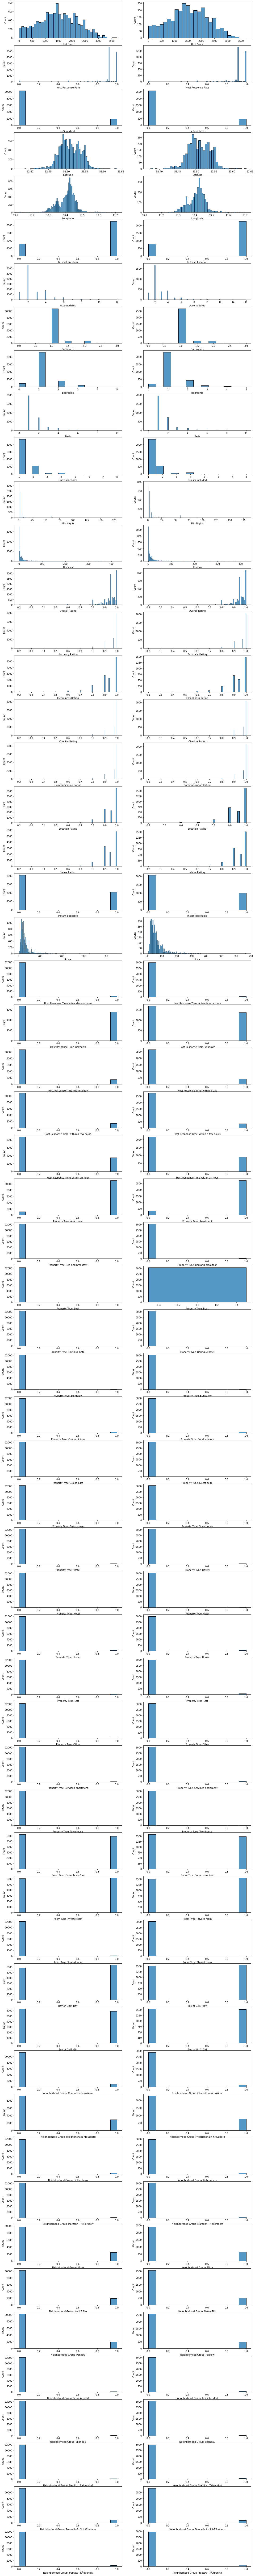

In [17]:
fig = plt.figure(figsize=(18, 200))
gs = GridSpec(len(data.columns), 2)

for index, feature in enumerate(data.columns):
    ax = fig.add_subplot(gs[index, 0])
    sb.histplot(train_set, x=feature, ax=ax)
    ax = fig.add_subplot(gs[index, 1])
    sb.histplot(test_set, x=feature, ax=ax)

plt.plot()

We can see that all variable distributions very alicke in both train and test sets. We conclude that there is no need to stratify, so we keep our train/test split as is.

In [18]:
# If you want to you can check for specific variable proportions with this code

def feature_proportions(data, feature):
    return data[feature].value_counts() / len(data)


compare_props = pd.DataFrame({
    "Input_dataset": feature_proportions(data, 'Boy or Girl?_Boy'),
    "Train_set": feature_proportions(train_set, 'Boy or Girl?_Boy'),
    "Test_set": feature_proportions(test_set, 'Boy or Girl?_Boy')
}).sort_index()
compare_props["Test set. %error"] = 100 * compare_props["Test_set"] / compare_props["Input_dataset"] - 100
compare_props["Train set. %error"] = 100 * compare_props["Train_set"] / compare_props["Input_dataset"] - 100

compare_props

,Input_dataset,Train_set,Test_set,Test set. %error,Train set. %error
0,0.483102,0.480432,0.493779,2.210039,-0.55260
1,0.516898,0.519568,0.506221,-2.065540,0.51647


In [19]:
def create_matrices(train_set, test_set):
        
    X_train = train_set.drop('Price', axis=1)
    y_train = train_set["Price"].copy()

    X_test = test_set.drop("Price", axis=1)
    y_test = test_set["Price"].copy()
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = create_matrices(train_set, test_set)

# Standardize data

In [20]:
features = X_train.columns
initial_categorical_features = [
    'Is Superhost', 
    'Is Exact Location', 
    'Instant Bookable',
    'Host Response Time',
    'Property Type',
    'Room Type',
    'Boy or Girl',
    'Neighborhood Group'
]
numerical_features = []
categorical_features = []

for feature in features:
    for initial_categorical_feature in initial_categorical_features:
        if initial_categorical_feature in feature:
            categorical_features.append(feature)
    if feature not in categorical_features:
        numerical_features.append(feature)

In [21]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Linear Regression

### Looking for best subset
There are wy to much features to implement a brute force methode so we will use forward and backward stepwise selection

In [22]:
def forward(features):

    # build folds object
    kf_10 = KFold( n_splits=10, shuffle=True, random_state=42)
    
    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    results = []
    
    for d in remaining_features:
        MSE = -1*cross_val_score(LinearRegression(), X_train[features+[d]], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
        model = LinearRegression()
        regr = model.fit(X_train[features+[d]], y_train)
        results.append({"model":regr, "features":features+[d], "MSE":MSE})
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['MSE'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model


def backward(features):
    
    # build folds object
    kf_10 = KFold( n_splits=10, shuffle=True, random_state=42)
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        combo = list(combo)
        MSE = -1*cross_val_score(LinearRegression(), X_train[combo], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
        model = LinearRegression()
        regr = model.fit(X_train[combo], y_train)
        results.append({"model":regr, "features":combo, "MSE":MSE})
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['MSE'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [23]:
# Build best models acording to forward stepwise selection

models_fwd = pd.DataFrame(columns=["MSE", "features", "model"])

tic = time.time()
features = []

for i in range(1,len(X_train.columns)+1):  
    model = forward(features)
    models_fwd.loc[i] = model
    features = model['features']

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Total elapsed time: 127.66404795646667 seconds.


In [24]:
# Build best models acording to backward stepwise selection

models_bwd = pd.DataFrame(columns=["MSE", "features", "model"], index = range(1,len(X_train.columns)))

tic = time.time()
features = X_train.columns

while(len(features) > 1): 
    model = backward(features)
    models_bwd.loc[len(features)-1] = model
    features = model["features"]

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Total elapsed time: 185.21314096450806 seconds.


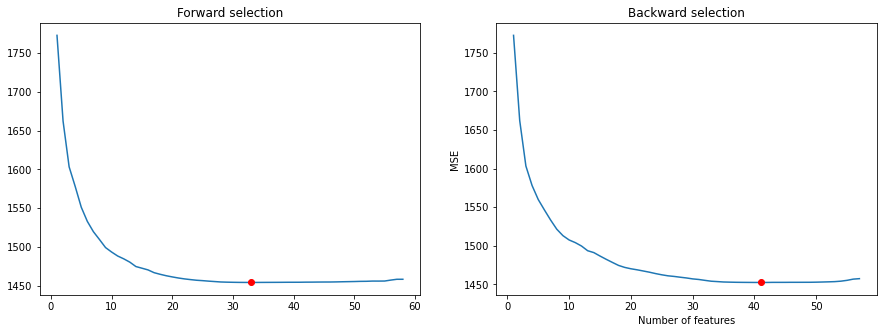

Minimum MSE achieved for forward selection: 33
Minimum MSE achieved for backward selection: 41


In [25]:
# Plot MSE of all selected models in order to chose the best feature subset possible

fig = plt.figure(figsize=(15,5)) 
(ax1, ax2) = fig.subplots(1, 2)

models_fwd = models_fwd.astype({'MSE': 'float64'})
ax1.plot(models_fwd["MSE"])
plt.xlabel('Number of features')
plt.ylabel('MSE')
ax1.set_title('Forward selection')
ax1.plot(models_fwd["MSE"].argmin()+1, models_fwd["MSE"].min(), "or")

models_bwd = models_bwd.astype({'MSE': 'float64'})
ax2.plot(models_bwd["MSE"])
plt.xlabel('Number of features')
plt.ylabel('MSE')
ax2.set_title('Backward selection')
ax2.plot(models_bwd["MSE"].argmin()+1, models_bwd["MSE"].min(), "or")

plt.show()

print('Minimum MSE achieved for forward selection: ' + str(models_fwd["MSE"].argmin()+1))
print('Minimum MSE achieved for backward selection: ' + str(models_bwd["MSE"].argmin()+1))

### Training 
To get the full model, we would train a new linear regression on the full data. But this project we will use the model trained only on training data in order to keep the test data for comparison with the other models we tried out. Here is the code I would have used to build this "full" model.

In [26]:
'''

X = data.drop('Price', axis=1)
y = data["Price"].copy()
        
std_scaler = StandardScaler()
std_scaler.fit(X[numerical_features])
X[numerical_features] = std_scaler.transform(X[numerical_features])


# Build best 33 feature model acording to forward stepwise selection

def forward_full_dataset(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    results = []
    
    for d in remaining_features:
        model = LinearRegression()
        MSE = -1*cross_val_score(model, X[features+[d]], y, cv=kf_10, scoring='neg_mean_squared_error').mean()
        regr = model.fit(X[features+[d]], y)
        results.append({"model":regr, "features":features+[d], "MSE":MSE})
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['MSE'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_final = pd.DataFrame(columns=["MSE", "features", "model"])

tic = time.time()
features = []

for i in range(1,34):  
    model = forward_full_dataset(features)
    models_final.loc[i] = model
    features = model["features"]

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")


print(models_final.loc[33, "features"])

'''

'\n\nX = data.drop(\'Price\', axis=1)\ny = data["Price"].copy()\n        \nstd_scaler = StandardScaler()\nstd_scaler.fit(X[numerical_features])\nX[numerical_features] = std_scaler.transform(X[numerical_features])\n\n\n# Build best 33 feature model acording to forward stepwise selection\n\ndef forward_full_dataset(features):\n\n    # Pull out features we still need to process\n    remaining_features = [d for d in X_train.columns if d not in features]\n    \n    results = []\n    \n    for d in remaining_features:\n        model = LinearRegression()\n        MSE = -1*cross_val_score(model, X[features+[d]], y, cv=kf_10, scoring=\'neg_mean_squared_error\').mean()\n        regr = model.fit(X[features+[d]], y)\n        results.append({"model":regr, "features":features+[d], "MSE":MSE})\n    \n    # Wrap everything up in a nice dataframe\n    models = pd.DataFrame(results)\n    \n    # Choose the model with the highest RSS\n    best_model = models.loc[models[\'MSE\'].argmin()]\n    \n    # Ret

### Testing
As explained above, for the testing we will use the model trained only on the training set in order to be able to compare it to the other models we are trying out in other notebooks.

In [27]:
model = models_fwd.loc[33, "model"]
features = models_fwd.loc[33, "features"]
y_pred = model.predict(X_test[features])

print('Model features: '+str(features))

Model features: ['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Bedrooms', 'Property Type_Loft', 'Property Type_Hotel', 'Guests Included', 'Location Rating', 'Property Type_Serviced apartment', 'Neighborhood Group_Mitte', 'Host Response Time_unknown', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Neighborhood Group_Charlottenburg-Wilm.', 'Neighborhood Group_Pankow', 'Latitude', 'Cleanliness Rating', 'Value Rating', 'Min Nights', 'Property Type_Boutique hotel', 'Overall Rating', 'Property Type_Condominium', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Private room', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Marzahn - Hellersdorf', 'Longitude', 'Neighborhood Group_Reinickendorf', 'Property Type_Hostel', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Is Superhost', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Host Since']


In [30]:
MSE = mean_squared_error(y_pred, y_test) 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_pred, y_test)
adj_rsquared = 1 - (1-model.score(X_test[features], y_test))*(len(y_test)-1)/(len(y_test)-X_test[features].shape[1]-1)

print('Model MSE on test set: '+str(MSE))
print('Model RMSE on test set: '+str(RMSE))
print('Model MAE on test set: '+str(MAE))
print('Model adjusted R-square on test set: '+str(adj_rsquared))

Model MSE on test set: 1039.4734541692524
Model RMSE on test set: 32.24086621307269
Model MAE on test set: 20.44708903437829
Model adjusted R-square on test set: 0.469321451360749


<AxesSubplot:ylabel='Count'>

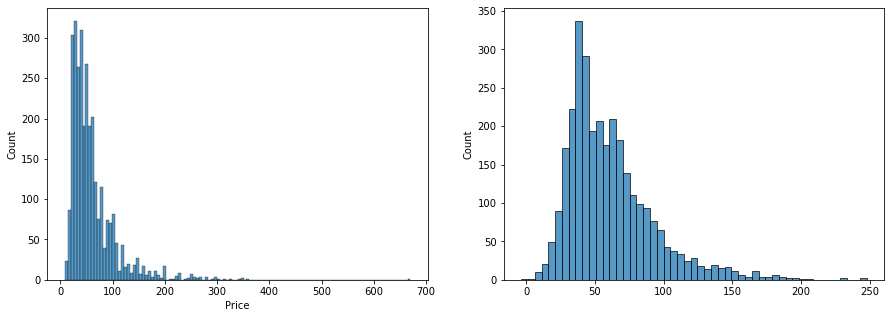

In [31]:
# Prediction distribution against real distribution

fig = plt.figure(figsize=(15,5)) 
(ax1, ax2) = fig.subplots(1, 2)

sb.histplot(y_test, ax=ax1)
sb.histplot(y_pred, ax=ax2)

We observe that altough the distributions are alike, high prices cannot be predicted correctly. A lot of the error is probably explained by theses extreme points.

In [32]:
# Importance of each feature in the predictions

correlations = {}

for feature in features:
    correlations[pearsonr(X_test[feature], y_pred)[0]] = feature
sorted_correlations = sorted(correlations.keys(), reverse=True)

print('Correlations in order :')
print(' ')
for r in sorted_correlations:
    print('Between the prediction and '+ correlations[r] + ' : r=' + str(r))

Correlations in order :
 
Between the prediction and Accomodates : r=0.7982351628604524
Between the prediction and Bedrooms : r=0.6530811630590051
Between the prediction and Room Type_Entire home/apt : r=0.6504124506302416
Between the prediction and Guests Included : r=0.5514741101316101
Between the prediction and Bathrooms : r=0.41572202444059314
Between the prediction and Property Type_Loft : r=0.26753990826808566
Between the prediction and Property Type_Serviced apartment : r=0.20815746094369522
Between the prediction and Property Type_Hotel : r=0.14390028822308648
Between the prediction and Is Superhost : r=0.13336940541089684
Between the prediction and Cleanliness Rating : r=0.11830982528830966
Between the prediction and Neighborhood Group_Mitte : r=0.11415212922506335
Between the prediction and Location Rating : r=0.10862267818466467
Between the prediction and Latitude : r=0.09709022327914613
Between the prediction and Neighborhood Group_Charlottenburg-Wilm. : r=0.079740253241687

Testing results are discussed in the report

# Alternative : build linear regression after dimentionality reduction through a PCA

### PCA

In [33]:
pca = PCA()
X_reduced = pca.fit_transform(scale(data.drop('Price', axis=1)))
y = data['Price']

X_reduced_train, X_reduced_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

We use 10-fold cross validation to see how the principal components influence the MSE.

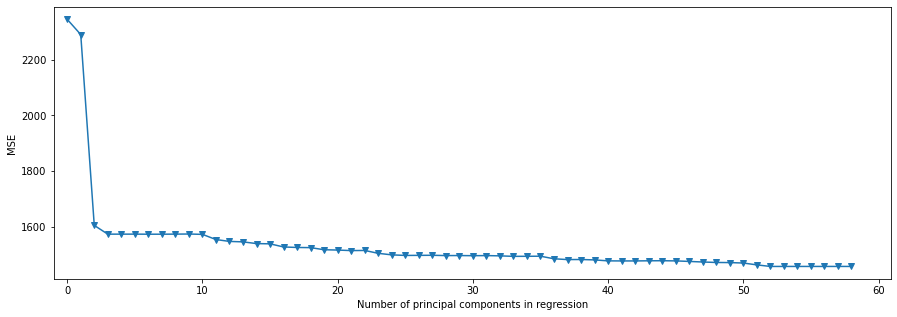

In [34]:
# 10-fold CV, with shuffle
n = len(X_reduced_train)

kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 58 principal components, adding one component at the time.
for i in np.arange(1, len(X_reduced_train[0])+1):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.figure(figsize=(15,5))
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1);

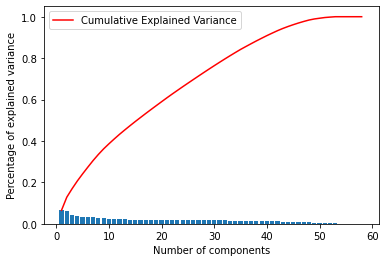

In [35]:
# Part of explained variance per component

plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_ ),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

If we were to use the 80% of explained variance rule, we would choose around 35 features. Nevertheless, we will try out different numbers of selected principal components and compared the results for each.

We choose 3, 11, 36 and 51 as they represent the discontinuity points in the MSE plot.

### Model with 3 components.

In [36]:
pca_3 = PCA(n_components = 3)
pca_3.fit(scale(data.drop('Price', axis=1)))

model_3 = LinearRegression()
model_3 = model_3.fit(X_reduced_train[:,:3], y_train)

y_pred_3 = model_3.predict(X_reduced_test[:,:3])

Text(0.5, 1.0, 'The effect of features on each components')

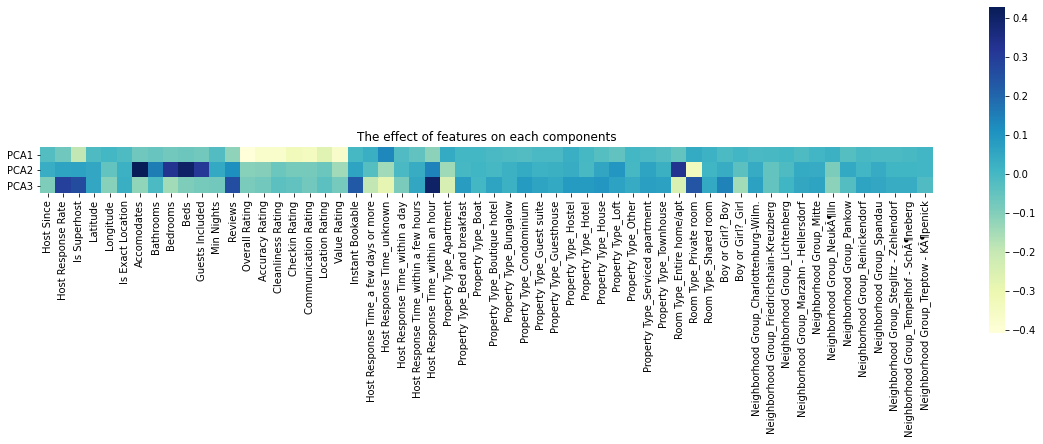

In [37]:
# How do the components influence the initial variables ?

plt.figure(figsize=(20,6))
ax = sns.heatmap(pca_3.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca_3.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

- A mixture of the rating features drive the first principal component.
- Accomodates, Bathrooms, Bedrooms, Beds, Guests included and Room type mainly drive the second.
- Host Response Rate, Is Superhost, Instant Bookable, Host Response Time and Property Type are the main drivers of the third.

We can see that most of theses are also the features that were kept in our 33 feature model after forward stepwise selection. Nevertheless, features such as Latitude and different Neighborhood Groups are missing, so there is probably still a good amount of variance to be explained.

Still, keep in mind that this is only a 3 feature model! So if it predicts well, it could gain a huge amount of data space and be very quick compared to the 'all features' model.

### Model with 11 components

In [38]:
pca_11 = PCA(n_components = 11)
pca_11.fit(scale(data.drop('Price', axis=1)))

model_11 = LinearRegression()
model_11 = model_11.fit(X_reduced_train[:,:11], y_train)

y_pred_11 = model_11.predict(X_reduced_test[:,:11])

Text(0.5, 1.0, 'The effect of features on each components')

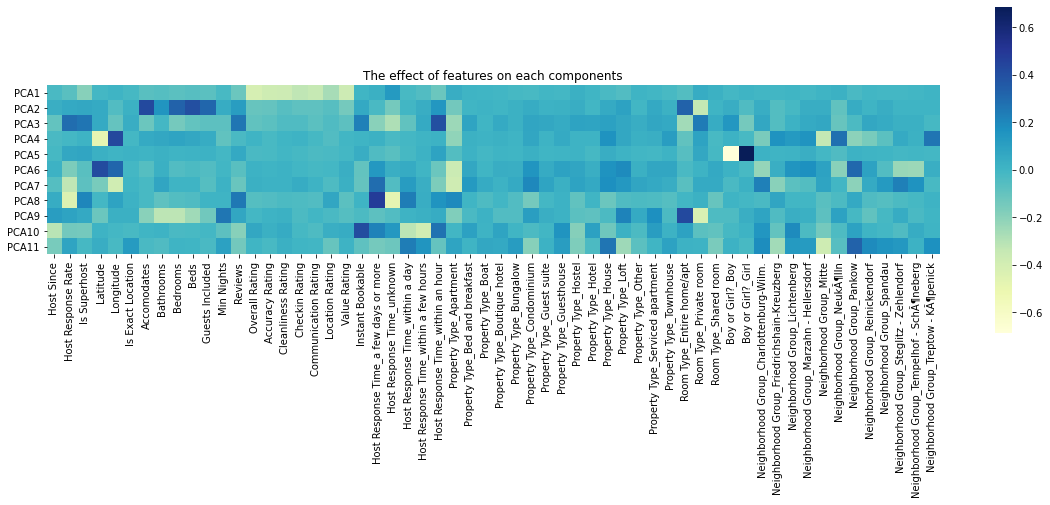

In [39]:
# How do the components influence the initial variables ?

plt.figure(figsize=(20,6))
ax = sns.heatmap(pca_11.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca_11.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

- Latitude, Longitude and Neighborhood groups gradually appear in the principal components.
- At this point, a good amount of the variance is probably explained already.

### Model with 36 components

In [40]:
pca_36 = PCA(n_components = 36)
pca_36.fit(scale(data.drop('Price', axis=1)))

model_36 = LinearRegression()
model_36 = model_36.fit(X_reduced_train[:,:36], y_train)

y_pred_36 = model_36.predict(X_reduced_test[:,:36])

Text(0.5, 1.0, 'The effect of features on each components')

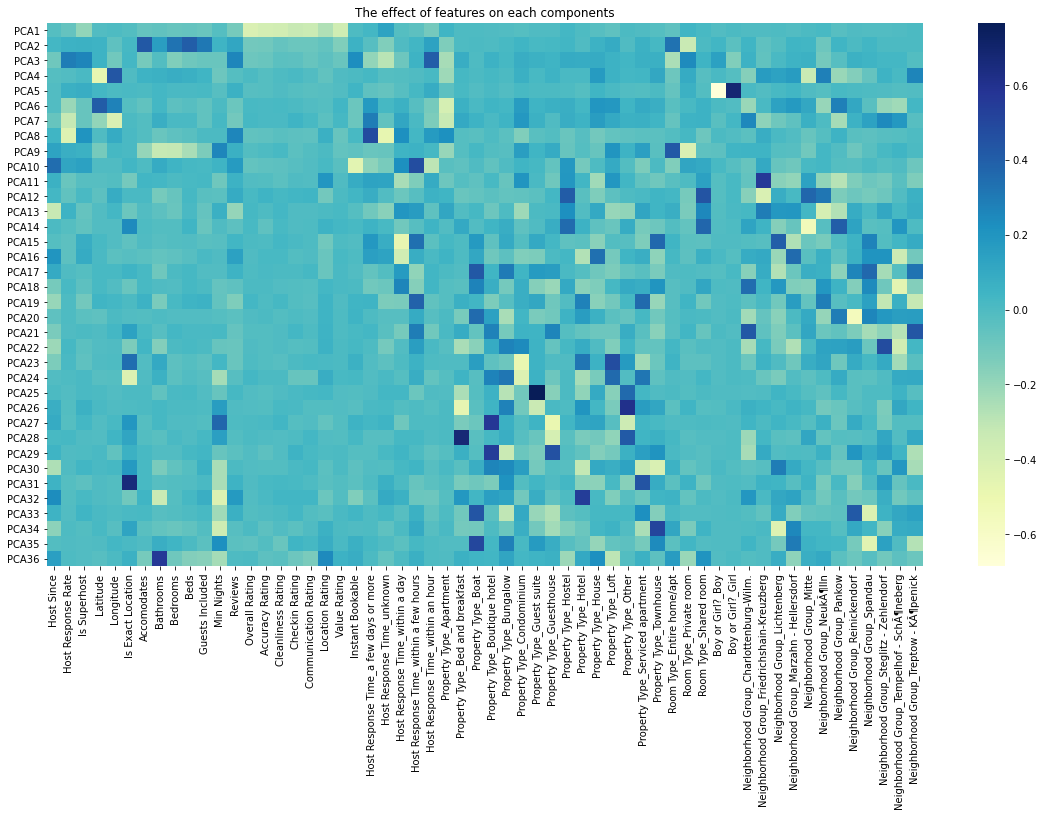

In [41]:
# How do the components influence the initial variables ?

plt.figure(figsize=(20,10))
ax = sns.heatmap(pca_36.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca_36.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

### Model with 51 components

In [42]:
pca_51 = PCA(n_components = 51)
pca_51.fit(scale(data.drop('Price', axis=1)))

model_51 = LinearRegression()
model_51 = model_51.fit(X_reduced_train[:,:51], y_train)

y_pred_51 = model_51.predict(X_reduced_test[:,:51])

Text(0.5, 1.0, 'The effect of features on each components')

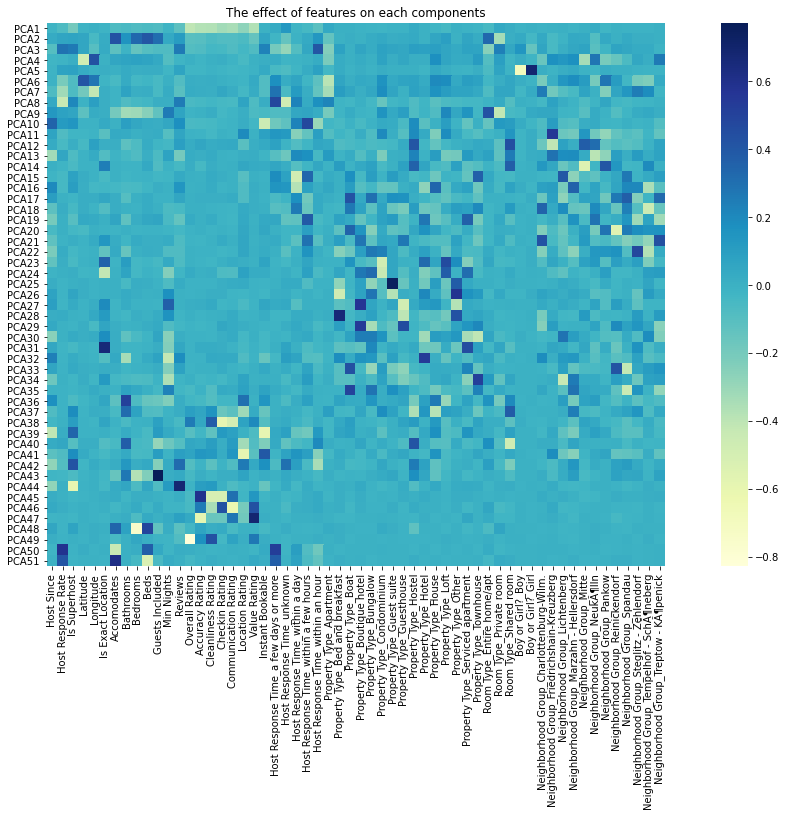

In [43]:
# How do the components influence the initial variables ?

plt.figure(figsize=(20,10))
ax = sns.heatmap(pca_51.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca_51.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

### Testing

In [45]:
print('3 components model: ')
MSE = mean_squared_error(y_pred_3, y_test) 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_pred_3, y_test)
adj_rsquared = 1 - (1-model_3.score(X_reduced_test[:,:3], y_test))*(len(y_test)-1)/(len(y_test)-X_reduced_test[:,:3].shape[1]-1)
print('Model MSE on test set: '+str(MSE))
print('Model RMSE on test set: '+str(RMSE))
print('Model MAE on test set: '+str(MAE))
print('Model adjusted R-square on test set: '+str(adj_rsquared))

3 components model: 
Model MSE on test set: 1133.3452377996366
Model RMSE on test set: 33.665193268413546
Model MAE on test set: 21.050710561516194
Model adjusted R-square on test set: 0.4270886086554432


In [46]:
print('11 components model: ')
MSE = mean_squared_error(y_pred_11, y_test) 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_pred_11, y_test)
adj_rsquared = 1 - (1-model_11.score(X_reduced_test[:,:11], y_test))*(len(y_test)-1)/(len(y_test)-X_reduced_test[:,:11].shape[1]-1)
print('Model MSE on test set: '+str(MSE))
print('Model RMSE on test set: '+str(RMSE))
print('Model MAE on test set: '+str(MAE))
print('Model adjusted R-square on test set: '+str(adj_rsquared))

11 components model: 
Model MSE on test set: 1117.8145311214305
Model RMSE on test set: 33.43373343079457
Model MAE on test set: 20.93637110042179
Model adjusted R-square on test set: 0.43345343073023457


In [47]:
print('36 components model: ')
MSE = mean_squared_error(y_pred_36, y_test) 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_pred_36, y_test)
adj_rsquared = 1 - (1-model_36.score(X_reduced_test[:,:36], y_test))*(len(y_test)-1)/(len(y_test)-X_reduced_test[:,:36].shape[1]-1)
print('Model MSE on test set: '+str(MSE))
print('Model RMSE on test set: '+str(RMSE))
print('Model MAE on test set: '+str(MAE))
print('Model adjusted R-square on test set: '+str(adj_rsquared))

36 components model: 
Model MSE on test set: 1067.6504812476521
Model RMSE on test set: 32.674921289081205
Model MAE on test set: 20.58674589099846
Model adjusted R-square on test set: 0.4543943452802589


In [49]:
print('51 components model: ')
MSE = mean_squared_error(y_pred_51, y_test) 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_pred_51, y_test)
adj_rsquared = 1 - (1-model_51.score(X_reduced_test[:,:51], y_test))*(len(y_test)-1)/(len(y_test)-X_reduced_test[:,:51].shape[1]-1)
print('Model MSE on test set: '+str(MSE))
print('Model RMSE on test set: '+str(RMSE))
print('Model MAE on test set: '+str(MAE))
print('Model adjusted R-square on test set: '+str(adj_rsquared))

51 components model: 
Model MSE on test set: 1047.1854633729333
Model RMSE on test set: 32.360245106811746
Model MAE on test set: 20.45637072243023
Model adjusted R-square on test set: 0.462178710391119


Results are discussed in the report.

# Feature analysis using shapley values
For this we will use the model which would be used in "production", that is to say the one trained on all the data we have.

In [50]:
model = models_fwd.loc[33, "model"]
features = models_fwd.loc[33, "features"]

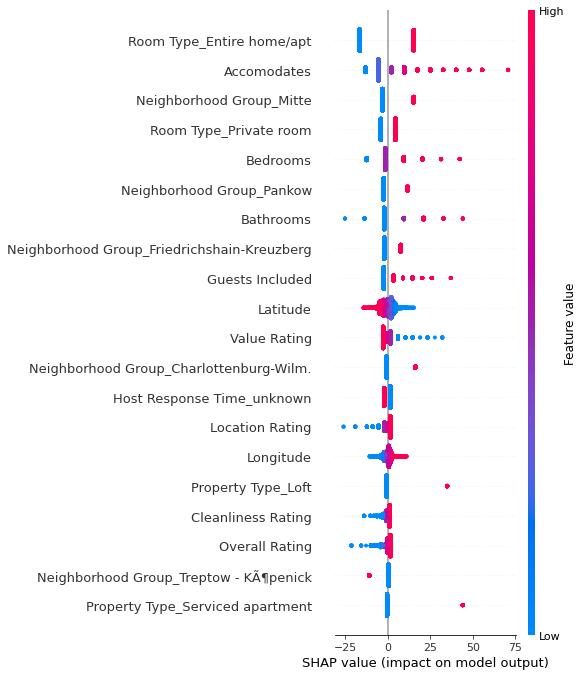

In [51]:
shap.initjs()
explainer = shap.LinearExplainer(model, X_train[features])
shap_values = explainer.shap_values(X_train[features])
shap.summary_plot(shap_values, X_train[features], features)

Here the shap values are measured on the train set. This means that the summary plot shows how the training features drive the model. 